# Plot results using the DataFrame stored in pickle file

In [1]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import numpy as np
import pandas as pd
import glob,imp,os,shutil
from pandas.io.json import json_normalize
import pyslha
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from collections import OrderedDict
import seaborn as sns
from scipy.interpolate import interp1d
from IPython.display import display, Markdown

pd.option_context('display.max_columns', -1)

pd.options.mode.chained_assignment = None #Disable copy warnings
# plt.style.use('fivethirtyeight') #Set style
# mpl.rcParams.update({'figure.figsize' : (15,10)})  #Set general plotting options
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.cm.get_cmap('RdYlBu')

In [2]:
#Merge with SModelS DataFrame
dataDF = pd.read_pickle('EWino_scanRandom.pcl')
# print(dataDF.columns.values.tolist()) #Print all columns names

#### Set r = 0 for points with no results 

In [3]:
#Set points without results with r == 0
dataDF.fillna(value={'ExptRes.result0.r' : 0.0},inplace=True)
#Sort points according to r value:
dataDF = dataDF.sort_values(by=['ExptRes.result0.r'],ascending=False)

#### Define exclusions

In [4]:
#Add simple flag for excluded points:
dataDF['excludedLHC'] = dataDF['ExptRes.result0.r'] > 1.0
dataDF['excludedRelic'] = dataDF['Omega'] > 0.13
#Xenon 1T curve (from micromegas):
data_1t_lnM = [1.790E+00, 1.885E+00, 2.006E+00, 2.148E+00, 2.297E+00, 2.449E+00, 2.598E+00, 2.783E+00, 2.961E+00, 3.117E+00, 3.302E+00, 3.444E+00, 3.614E+00, 3.796E+00, 4.037E+00, 4.268E+00, 4.581E+00, 4.904E+00, 5.178E+00, 5.441E+00, 5.768E+00, 6.095E+00, 6.369E+00, 6.550E+00, 6.891E+00]
data_1t_lnS = [1.040E+00, 2.794E-02,-1.003E+00,-2.035E+00,-2.888E+00,-3.591E+00,-4.144E+00,-4.717E+00,-5.111E+00,-5.326E+00,-5.458E+00,-5.486E+00,-5.440E+00,-5.375E+00,-5.178E+00,-4.982E+00,-4.711E+00,-4.412E+00,-4.150E+00,-3.925E+00,-3.598E+00,-3.270E+00,-3.009E+00,-2.812E+00,-2.485E+00]
xenonF = interp1d(data_1t_lnM,data_1t_lnS,
                  bounds_error=False,fill_value="extrapolate") #interpolate in log
@np.vectorize
def xenonUL(mDM):
    return 1e-8*np.exp(xenonF(np.log(mDM))) #90% upper limit on sigmaNucleon (pb)

rDD = (dataDF['Omega']/0.12)*(dataDF['proton_SI']+dataDF['neutron_SI'])/2.0
rDD = rDD/xenonUL(dataDF['mass.1000022'])
dataDF['excludedDD'] = (rDD > 1)

#### Add c*tau column for charginos

In [5]:
dataDF['ctau.1000024'] = 1.967e-16/dataDF['width.1000024']

### Get points excluded:

In [6]:
excluded = dataDF[dataDF['excludedLHC'] == True]
excludedDM = dataDF[(dataDF['excludedLHC'] == False) & (dataDF['excludedRelic'] == True)]
excludedDD = dataDF[(dataDF['excludedLHC'] == False) & (dataDF['excludedRelic'] == False) 
                    & (dataDF['excludedDD'] == True)]

allowed = dataDF[(dataDF['excludedLHC'] == False) & (dataDF['excludedRelic'] == False) 
                 & (dataDF['excludedDD'] == False)]

allowedLHC = dataDF[(dataDF['excludedLHC'] == False)]


print('Total number of points = %i' %len(dataDF))
print('Total excluded (LHC) = %i'%(len(excluded)))
print('Total excluded (relic) = %i'%(len(excludedDM)))
print('Total excluded (DD) = %i'%(len(excludedDD)))
print('Total allowed = %i\n'%(len(allowed)))

# print('Total excluded (r > %1.2f) = %i'%(rscale,len(excludedSC)))
# print('Total allowed (r > %1.2f) = %i'%(rscale,len(allowedSC)))


Total number of points = 96629
Total excluded (LHC) = 7269
Total excluded (relic) = 42067
Total excluded (DD) = 11756
Total allowed = 35537



### Create analysis label for excluded points

In [45]:
anas = excluded['ExptRes.result0.AnalysisID'].value_counts()
anas.sort_values(inplace=True,ascending=False)
processDict = {'TChiWZ' : r'$\chi_1^\pm \, \chi_2^0 \to W^{(*)} \chi_1^0 \, Z^{(*)} \chi_1^0$',
              'TChiWH' : r'$\chi_1^\pm \, \chi_2^0 \to W \chi_1^0 \, h \chi_1^0$',
              'TChiWW' : r'$\chi_1^\pm \, \chi_1^\mp \to W \chi_1^0 \, W \chi_1^0$',
              'TDTM1F,TDTM2F' : r'$\chi_1^\pm \to \pi^\pm \chi_1^0$'}
labels = []
for index, row in excluded.iterrows():
    ana = row['ExptRes.result0.AnalysisID']
    txList = sorted(row['ExptRes.result0.TxNames'])
    label = ana + ' (' + ','.join(txList) + ')'
    label = label.replace('off','') #Group together on and off-shell topologies
    #Replace txnames by process
    for txlabel,proc in processDict.items():
        label = label.replace(txlabel,proc) 
    labels.append(label)
excluded['label'] = labels


In [88]:
nexcluded = [[len(excluded[excluded['label'] == label]),label] for label in excluded['label'].unique()]
nexcluded = sorted(nexcluded,reverse=True)
nexcluded = np.array(nexcluded)
for label in nexcluded[:,1]:
    display(Markdown(label+': %i'%len(excluded[excluded['label'] == label])))

ATLAS-SUSY-2016-06 ($\chi_1^\pm \to \pi^\pm \chi_1^0$): 6590

ATLAS-SUSY-2019-08 ($\chi_1^\pm \, \chi_2^0 \to W \chi_1^0 \, h \chi_1^0$): 466

CMS-SUS-17-004 ($\chi_1^\pm \, \chi_2^0 \to W^{(*)} \chi_1^0 \, Z^{(*)} \chi_1^0$): 93

ATLAS-SUSY-2018-32 ($\chi_1^\pm \, \chi_1^\mp \to W \chi_1^0 \, W \chi_1^0$): 48

ATLAS-SUSY-2018-06 ($\chi_1^\pm \, \chi_2^0 \to W^{(*)} \chi_1^0 \, Z^{(*)} \chi_1^0$): 41

CMS-EXO-19-010 ($\chi_1^\pm \to \pi^\pm \chi_1^0$): 18

ATLAS-SUSY-2016-24 ($\chi_1^\pm \, \chi_2^0 \to W^{(*)} \chi_1^0 \, Z^{(*)} \chi_1^0$): 7

CMS-SUS-13-006 ($\chi_1^\pm \, \chi_2^0 \to W^{(*)} \chi_1^0 \, Z^{(*)} \chi_1^0$): 3

CMS-SUS-16-039 ($\chi_1^\pm \, \chi_2^0 \to W^{(*)} \chi_1^0 \, Z^{(*)} \chi_1^0$): 1

ATLAS-SUSY-2017-03 ($\chi_1^\pm \, \chi_2^0 \to W^{(*)} \chi_1^0 \, Z^{(*)} \chi_1^0$): 1

ATLAS-SUSY-2013-12 ($\chi_1^\pm \, \chi_2^0 \to W^{(*)} \chi_1^0 \, Z^{(*)} \chi_1^0$): 1

### Define colors and plotting order

In [118]:
colors = sns.color_palette("Paired",len(excluded['label'].unique()))
colorDict = {'ATLAS-SUSY-2016-06 (TDTM1F,TDTM2F)' : colors[6], #light orange
             'ATLAS-SUSY-2019-08 (TChiWH)' : colors[5], #red
             'CMS-SUS-17-004 (TChiWZ)' : colors[1], #dark blue
             'ATLAS-SUSY-2018-32 (TChiWW)' : colors[3], #dark green
             'ATLAS-SUSY-2018-06 (TChiWZ)' : colors[0], #light blue
             'CMS-EXO-19-010 (TDTM1F,TDTM2F)' : colors[7], #dark orange
             'Other' : colors[8] #light purple
             }
colorDictNew = {}
for key,val in list(colorDict.items())[:]:
    newkey = key
    #Replace txnames by process
    for txlabel,proc in processDict.items():
        newkey = newkey.replace(txlabel,proc)
    colorDictNew[newkey] = val
colorDict = colorDictNew

#Define plotting order:
plottingOrder = ['ATLAS-SUSY-2016-06 (TDTM1F,TDTM2F)','CMS-EXO-19-010 (TDTM1F,TDTM2F)',
                 'ATLAS-SUSY-2019-08 (TChiWH)', 'CMS-SUS-17-004 (TChiWZ)',
                 'ATLAS-SUSY-2018-06 (TChiWZ)','ATLAS-SUSY-2018-32 (TChiWW)']
#Add other analyses
for ana in excluded['label'].unique():
    if not ana in plottingOrder:
        plottingOrder.append(ana)
        
for i,ana in enumerate(plottingOrder):
    for txlabel,proc in processDict.items():
        newkey = newkey.replace(txlabel,proc)
    

### Get relevant official exclusion curves

In [119]:
excCurves = {}
excATLAS = np.genfromtxt('../EWino/data/HEPData-ins1641262-v4-Exclusion_contour_EW_2_obs_conv.txt',
                       names=True)

excCurves['ATLAS-SUSY-2016-06 (TDTM1F,TDTM2F)'] = np.array(list(zip(excATLAS['mC1_GeV'],1.967e-16/excATLAS['width_GeV'])))


excCurves['CMS-SUS-17-004 (TChiWZ)'] =  np.genfromtxt('../EWino/data/CMS_SUS_17_004_TChiWZ_obs.csv', 
                                                      delimiter=',')
excCurves['ATLAS-SUSY-2016-24 (TChiWZ)'] = np.genfromtxt('../EWino/data/HEPData-ins1658902-v1-Table_20.csv',
                       delimiter=',', skip_header=9)
excCurves['ATLAS-SUSY-2019-08 (TChiWH)'] = np.genfromtxt('../EWino/data/HEPData-ins1755298-v1-Observed_limit_1lbb.csv',
                       delimiter=',', skip_header=11)
excCurves['ATLAS-SUSY-2018-32 (TChiWW)'] = np.genfromtxt('../EWino/data/HEPData-ins1750597-v1-Exclusion_contour_(obs)_1.csv',
                       delimiter=',', skip_header=10)
excCurves['CMS-SUS-13-006 (TChiWZ)'] = np.genfromtxt('../EWino/data/CMS_SUS_13_006_TChiWZ_obs.csv', 
                                                      delimiter=',')

excCurves['CMS-EXO-19-010 (TDTM1F,TDTM2F)'] = np.genfromtxt('../EWino/data/CMS_SUS_19_010_TChiWZ_obs.csv', 
                                                      delimiter=',')
#Fix column order:
excCurves['CMS-EXO-19-010 (TDTM1F,TDTM2F)'][:,[0,1]] = excCurves['CMS-EXO-19-010 (TDTM1F,TDTM2F)'][:,[1,0]]
#Convert width to lifetime
excCurves['CMS-EXO-19-010 (TDTM1F,TDTM2F)'][:,1]= 1.967e-16/excCurves['CMS-EXO-19-010 (TDTM1F,TDTM2F)'][:,1]

#Add official curves but using process labels:
excCurvesNew = {}
for key,val in list(excCurves.items())[:]:
    newkey = key
    #Replace txnames by process
    for txlabel,proc in processDict.items():
        newkey = newkey.replace(txlabel,proc)
    excCurvesNew[newkey] = val
excCurves = excCurvesNew

#### Plot distribution excluded points

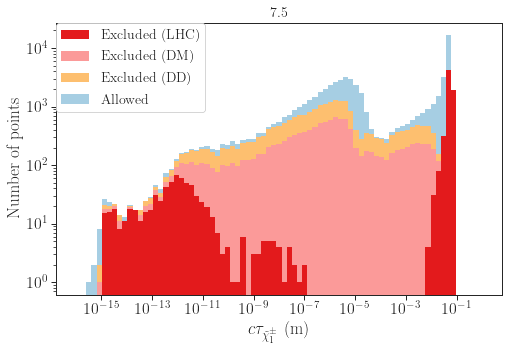

In [120]:
plt.figure(figsize=(8,5))
xExcluded = excluded['ctau.1000024']
xExcludedDM = excludedDM['ctau.1000024']
xExcludedDD = excludedDD['ctau.1000024']
xAllowed = allowed['ctau.1000024']
nbins = np.logspace(-16,0,80)
colors = np.take(sns.color_palette("Paired"),[5,4,6,0],axis=0)
plt.hist([xExcluded,xExcludedDD,xExcludedDD,xAllowed],nbins,stacked=True, 
                            histtype='barstacked', label=['Excluded (LHC)','Excluded (DM)',
                                                          'Excluded (DD)','Allowed'],
                            linewidth=0, fill=True, color=colors)
lgd = plt.legend(loc='upper left', borderaxespad=0.,
                 prop={'family' :'serif','style' : 'italic', 'size' : 14},framealpha=1.)
plt.yscale('log')
plt.xscale('log')
plt.title('%1.1f%% excluded points' %(100*len(excluded)/float(len(dataDF))), fontsize=14)
plt.xlabel(r'$c \tau_{\tilde{\chi}_1^\pm}$ (m)')
plt.ylabel('Number of points')
plt.show()

### Plot excluded points grouped by most excluding analysis

ATLAS-SUSY-2016-06 ($\chi_1^\pm \to \pi^\pm \chi_1^0$)                                    6590
ATLAS-SUSY-2019-08 ($\chi_1^\pm \, \chi_2^0 \to W \chi_1^0 \, h \chi_1^0$)                 466
CMS-SUS-17-004 ($\chi_1^\pm \, \chi_2^0 \to W^{(*)} \chi_1^0 \, Z^{(*)} \chi_1^0$)          93
ATLAS-SUSY-2018-32 ($\chi_1^\pm \, \chi_1^\mp \to W \chi_1^0 \, W \chi_1^0$)                48
ATLAS-SUSY-2018-06 ($\chi_1^\pm \, \chi_2^0 \to W^{(*)} \chi_1^0 \, Z^{(*)} \chi_1^0$)      41
CMS-EXO-19-010 ($\chi_1^\pm \to \pi^\pm \chi_1^0$)                                          18
ATLAS-SUSY-2016-24 ($\chi_1^\pm \, \chi_2^0 \to W^{(*)} \chi_1^0 \, Z^{(*)} \chi_1^0$)       7
CMS-SUS-13-006 ($\chi_1^\pm \, \chi_2^0 \to W^{(*)} \chi_1^0 \, Z^{(*)} \chi_1^0$)           3
ATLAS-SUSY-2013-12 ($\chi_1^\pm \, \chi_2^0 \to W^{(*)} \chi_1^0 \, Z^{(*)} \chi_1^0$)       1
CMS-SUS-16-039 ($\chi_1^\pm \, \chi_2^0 \to W^{(*)} \chi_1^0 \, Z^{(*)} \chi_1^0$)           1
ATLAS-SUSY-2017-03 ($\chi_1^\pm \, \chi_2^0 \to W^

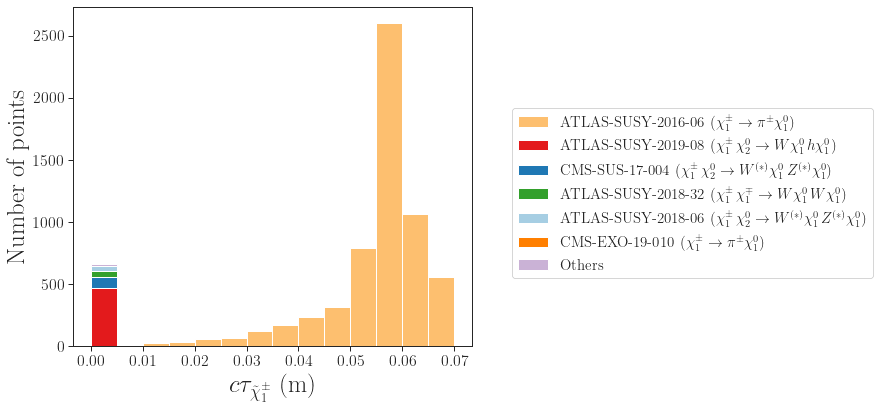

In [121]:
anas = excluded['label'].value_counts()
anas.sort_values(inplace=True,ascending=False)
print(anas)

plt.figure(figsize=(13,6))

# nbins = np.logspace(-3,3,20)
nbins=np.linspace(0,0.07,15)
c_other = colorDict['Other']
first = True
labels= []
hists = []
colors = []
xothers = []
for i,ana in enumerate(anas.index):
    x = excluded[excluded['label'] == ana]['ctau.1000024']
    if anas[ana] < 0 or (not ana in colorDict):
        xothers += x.tolist()        
        continue
    elif ana in colorDict:
        color = colorDict[ana]
        label = ana
    
    hists.append(x)
    colors.append(color)
    labels.append(label)

hists.append(xothers)
labels.append('Others')
colors.append(c_other)
plt.hist(hists,nbins,color=colors,label=labels,
                            histtype='barstacked',
                            linewidth=1, fill=True)

lgd = plt.legend(loc=(1.1,0.2), borderaxespad=0.,framealpha=1.,fontsize=15)

# plt.ylim(0,6500)
# plt.xlim(0,0.07)
# plt.title('SModelS v2.0', fontsize=26)
plt.xlabel(r'$c \tau_{\tilde{\chi}_1^\pm}$ (m)',fontsize = 25)
plt.ylabel('Number of points',fontsize = 25)
plt.tight_layout()
plt.savefig('Wino_v2.png')
plt.show()

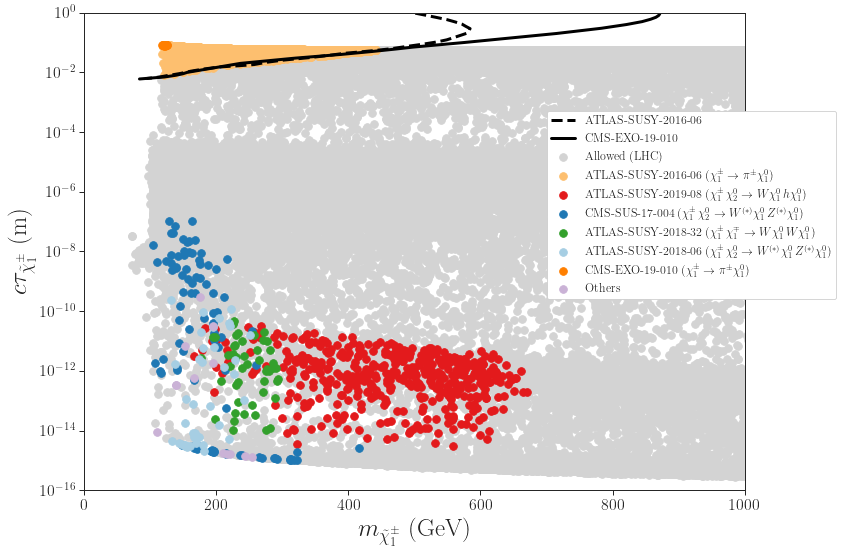

In [122]:
anas = excluded['label'].value_counts()
anas.sort_values(inplace=True,ascending=False)

plt.figure(figsize=(12,8))

x = allowedLHC['mass.1000024']
y = allowedLHC['ctau.1000024']
c_other = 'lightgray'
plt.scatter(x,y,color=c_other,label='Allowed (LHC)',s=60)

otherLabel = 'Others'
for i,ana in enumerate(anas.index):
    x = excluded[excluded['label'] == ana]['mass.1000024']
    y = excluded[excluded['label'] == ana]['ctau.1000024']
    if not ana in colorDict:
        color = colorDict['Other']        
        plt.scatter(x,y,color=color,label=otherLabel,s=60)
        otherLabel = None #suppress repeated label
    else:
        color = colorDict[ana]
        label = ana
        plt.scatter(x,y,color=color,label=label,s=60)

    
    
    
#Add official DT exclusion curve
offExc = excCurves[r'ATLAS-SUSY-2016-06 ($\chi_1^\pm \to \pi^\pm \chi_1^0$)']
c = colorDict[r'ATLAS-SUSY-2016-06 ($\chi_1^\pm \to \pi^\pm \chi_1^0$)']
plt.plot(offExc[:,0],offExc[:,1],label='ATLAS-SUSY-2016-06',linewidth=3,linestyle='--',color='black')
offExc = excCurves[r'CMS-EXO-19-010 ($\chi_1^\pm \to \pi^\pm \chi_1^0$)']
plt.plot(offExc[:,0],offExc[:,1],label='CMS-EXO-19-010',linewidth=3,linestyle='-',color='black')

lgd = plt.legend(loc=(0.7,0.4), framealpha=1.,fontsize=12)
plt.yscale('log')
plt.ylim(1e-16,1)
# plt.ylim(1e-2,0.1)
plt.xlim(0,1000)
# plt.xticks([0,200.,300.,400.,450.,500.,550.])
# plt.grid()
plt.xlabel(r'$m_{\tilde{\chi}_1^\pm}$ (GeV)',fontsize = 25)
plt.ylabel(r'$c \tau_{\tilde{\chi}_1^\pm}$ (m)',fontsize = 25)
plt.tight_layout()
plt.savefig('EWino_exclusion_ctau.png')
plt.savefig('EWino_exclusion_ctau.pdf')
plt.show()

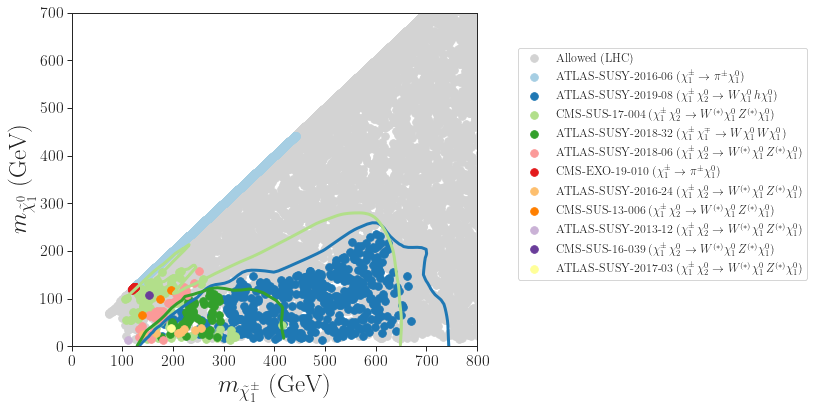

In [123]:
anas = excluded['label'].value_counts()
anas.sort_values(inplace=True,ascending=False)

plt.figure(figsize=(12,6))



colorDict = dict(zip(anas.index,sns.color_palette("Paired",len(anas))))
c_other = 'lightgray'
c_dm = 'darkgray'
c_dd = 'gray'


x = allowedLHC['mass.1000024']
y = allowedLHC['mass.1000022']
plt.scatter(x,y,color=c_other,label='Allowed (LHC)',s=60)

# x = excludedDM['mass.1000024']
# y = excludedDM['mass.1000022']
# plt.scatter(x,y,color=c_dm,label='Excluded (DM)',s=60)


# x = excludedDD['mass.1000024']
# y = excludedDD['mass.1000022']
# plt.scatter(x,y,color=c_dd,label='Excluded (DD)',s=60)

deleteCurves = ['CMS-EXO-19-010','ATLAS-SUSY-2016-06','ATLAS-SUSY-2016-24','CMS-SUS-13-006']

otherLabel = 'Others'
for ana in anas.index:
    x = excluded[excluded['label'] == ana]['mass.1000024']
    y = excluded[excluded['label'] == ana]['mass.1000022']
    if not ana in colorDict:
        color = colorDict['Other']        
        plt.scatter(x,y,color=color,label=otherLabel,s=60)
        otherLabel = None #suppress repeated label
    else:
        color = colorDict[ana]
        label = ana
        plt.scatter(x,y,color=color,label=label,s=60)

for ana in anas.index:
    if not ana in excCurves: continue
    if any(val in ana for val in deleteCurves): continue
    curve = excCurves[ana]
    color = colorDict[ana]
    plt.plot(curve[:,0],curve[:,1],linewidth=3,linestyle='-',color=color)
        

lgd = plt.legend(loc=(1.1,0.2), framealpha=1.,fontsize=12)

plt.ylim(0,700)
plt.xlim(0,800)
plt.xlabel(r'$m_{\tilde{\chi}_1^\pm}$ (GeV)',fontsize = 25)
plt.ylabel(r'$m_{\tilde{\chi}_1^0}$ (GeV)',fontsize = 25)
plt.tight_layout()
plt.savefig('EWino_exclusion_mass.png')
plt.savefig('EWino_exclusion_mass.pdf')
plt.show()

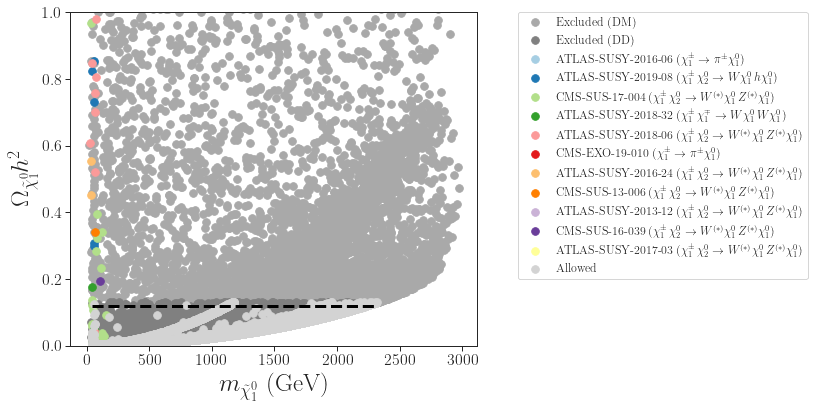

In [59]:
anas = excluded['label'].value_counts()
anas.sort_values(inplace=True,ascending=False)

plt.figure(figsize=(12,6))

colorDict = dict(zip(anas.index,sns.color_palette("Paired",len(anas))))
c_other = 'lightgray'
c_dm = 'darkgray'
c_dd = 'gray'


x = excludedDM['mass.1000022']
y = excludedDM['Omega']
plt.scatter(x,y,color=c_dm,label='Excluded (DM)',s=60)


x = excludedDD['mass.1000022']
y = excludedDD['Omega']
plt.scatter(x,y,color=c_dd,label='Excluded (DD)',s=60)


for ana in anas.index:
    x = excluded[excluded['label'] == ana]['mass.1000022']
    y = excluded[excluded['label'] == ana]['Omega']
    color = colorDict[ana]
    label = ana
    plt.scatter(x,y,color=color,label=label,s=60)

    
x = allowed['mass.1000022']
y = allowed['Omega']
plt.scatter(x,y,color=c_other,label='Allowed',s=60)

        
plt.hlines(y=0.12,xmin=allowed['mass.1000022'].min(),xmax=allowed['mass.1000022'].max(),
           linewidth=3,linestyle='--',color='black')
lgd = plt.legend(loc=(1.1,0.2), framealpha=1.,fontsize=12)

plt.ylim(0,1)
# plt.xlim(0,800)
plt.xlabel(r'$m_{\tilde{\chi}_1^0}$ (GeV)',fontsize = 25)
plt.ylabel(r'$\Omega_{\tilde{\chi}_1^0} h^2$',fontsize = 25)

plt.tight_layout()
plt.savefig('EWino_exclusion_DM.png')
plt.savefig('EWino_exclusion_DM.pdf')
plt.show()

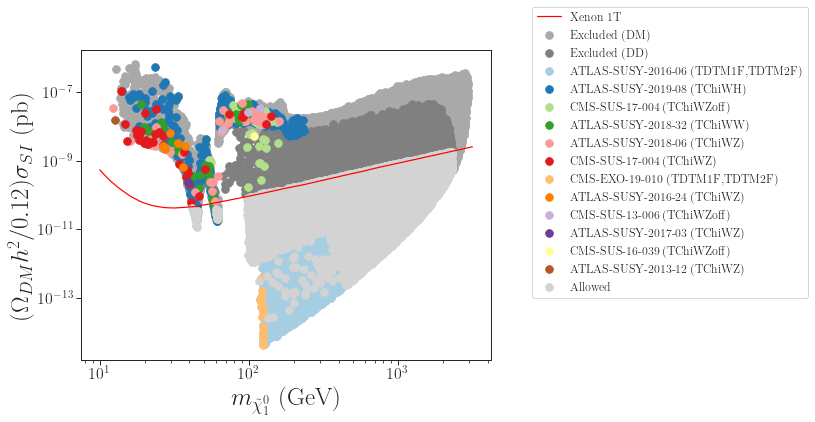

In [16]:
anas = excluded['label'].value_counts()
anas.sort_values(inplace=True,ascending=False)
mDMlist = np.logspace(1,3.5,100)
sigUL = xenonUL(mDMlist)

plt.figure(figsize=(12,6))

colorDict = dict(zip(anas.index,sns.color_palette("Paired",len(anas))))
c_other = 'lightgray'
c_dm = 'darkgray'
c_dd = 'gray'



x = excludedDM['mass.1000022']
y = (excludedDM['Omega']/0.12)*excludedDM['proton_SI']
plt.scatter(x,y,color=c_dm,label='Excluded (DM)',s=60)


x = excludedDD['mass.1000022']
y = (excludedDD['Omega']/0.12)*excludedDD['proton_SI']
plt.scatter(x,y,color=c_dd,label='Excluded (DD)',s=60)


for ana in anas.index:
    x = excluded[excluded['label'] == ana]['mass.1000022']
    y = (excluded[excluded['label'] == ana]['Omega']/0.12)*excluded[excluded['label'] == ana]['proton_SI']
    color = colorDict[ana]
    label = ana
    plt.scatter(x,y,color=color,label=label,s=60)

    
x = allowed['mass.1000022']
y = (allowed['Omega']/0.12)*allowed['proton_SI']
plt.scatter(x,y,color=c_other,label='Allowed',s=60)

        
plt.plot(mDMlist,sigUL,c='red',label='Xenon 1T')


lgd = plt.legend(loc=(1.1,0.2), framealpha=1.,fontsize=12)

# plt.ylim(0,1)
# plt.xlim(0,800)
plt.xlabel(r'$m_{\tilde{\chi}_1^0}$ (GeV)',fontsize = 25)
plt.ylabel(r'$(\Omega_{DM} h^2/0.12) \sigma_{SI}$ (pb)',fontsize = 25)
plt.yscale('log')
plt.xscale('log')
plt.tight_layout()
plt.savefig('EWino_exclusion_DD.png')
plt.savefig('EWino_exclusion_DD.pdf')
plt.show()

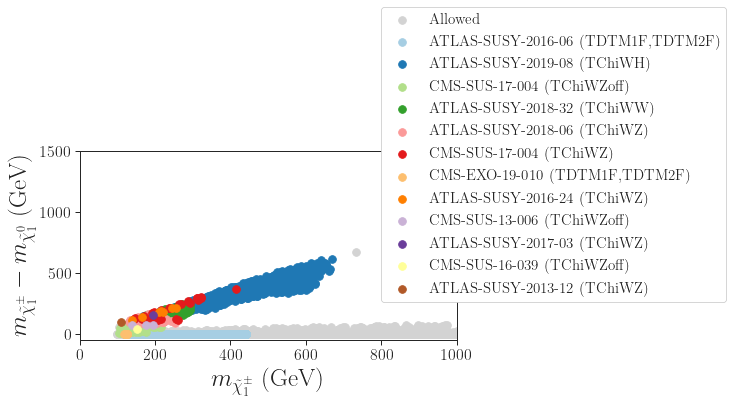

In [17]:
anas = excluded['label'].value_counts()
anas.sort_values(inplace=True,ascending=False)

plt.figure(figsize=(10,5))

colorDict = dict(zip(anas.index,sns.color_palette("Paired",len(anas))))
c_other = 'lightgray'


x = allowed['mass.1000024']
y = allowed['mass.1000022']
y = x-y
plt.scatter(x,y,color=c_other,label='Allowed',s=60)
for i,ana in enumerate(anas.index):
    x = excluded[excluded['label'] == ana]['mass.1000024']
    y = excluded[excluded['label'] == ana]['mass.1000022']
    y = x-y
    color = colorDict[ana]
    label = ana
    plt.scatter(x,y,color=color,label=label,s=60)


lgd = plt.legend(loc=(0.8,0.2), framealpha=1.,fontsize=15)

plt.ylim(-50,1500)
plt.xlim(0,1000)

plt.ylabel(r'$m_{\tilde{\chi}_1^\pm}-m_{\tilde{\chi}_1^0}$ (GeV)',fontsize = 25)
plt.xlabel(r'$m_{\tilde{\chi}_1^\pm}$ (GeV)',fontsize = 25)
plt.tight_layout()
plt.show()

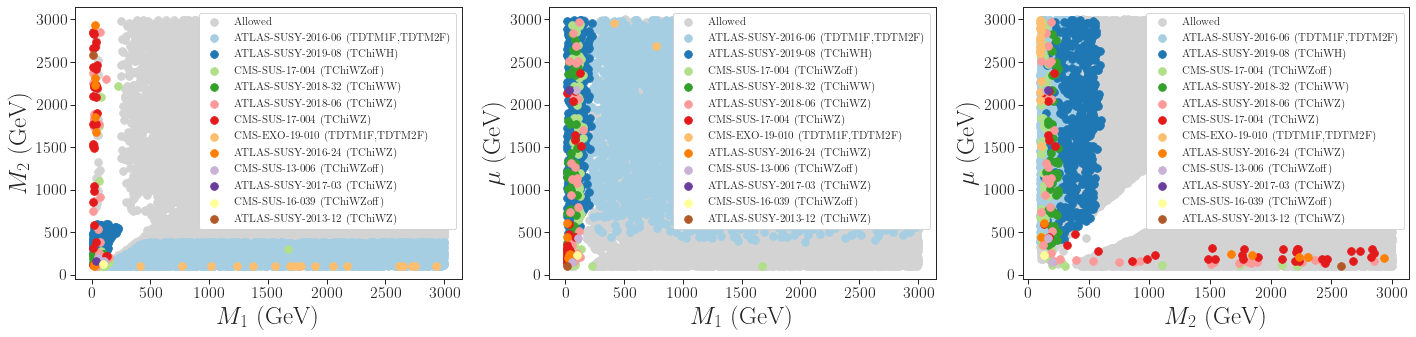

In [18]:
anas = excluded['label'].value_counts()
anas.sort_values(inplace=True,ascending=False)

colorDict = dict(zip(anas.index,sns.color_palette("Paired",len(anas))))
c_other = 'lightgray'


fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(20,5))
axislabels = {'extpar.1' : r'$M_1$ (GeV)',
              'extpar.2' : r'$M_2$ (GeV)',
              'extpar.23' : r'$\mu$ (GeV)'}
i = 0
for ix,xvar in enumerate(axislabels):
    for iy,yvar in enumerate(axislabels):
        if iy <= ix: continue
        ax = axes[i]
        x = allowed[xvar]
        y = allowed[yvar]
        ax.scatter(x,y,color=c_other,label='Allowed',s=60)
        for ana in anas.index:
            x = excluded[excluded['label'] == ana][xvar]
            y = excluded[excluded['label'] == ana][yvar]
            color = colorDict[ana]
            label = ana
            ax.scatter(x,y,color=color,label=label,s=60)
        ax.set_ylabel(axislabels[yvar],fontsize = 25)
        ax.set_xlabel(axislabels[xvar],fontsize = 25)
        i += 1     
        lgd = ax.legend(loc='upper right', framealpha=1.,fontsize=11)




plt.tight_layout()
plt.show()



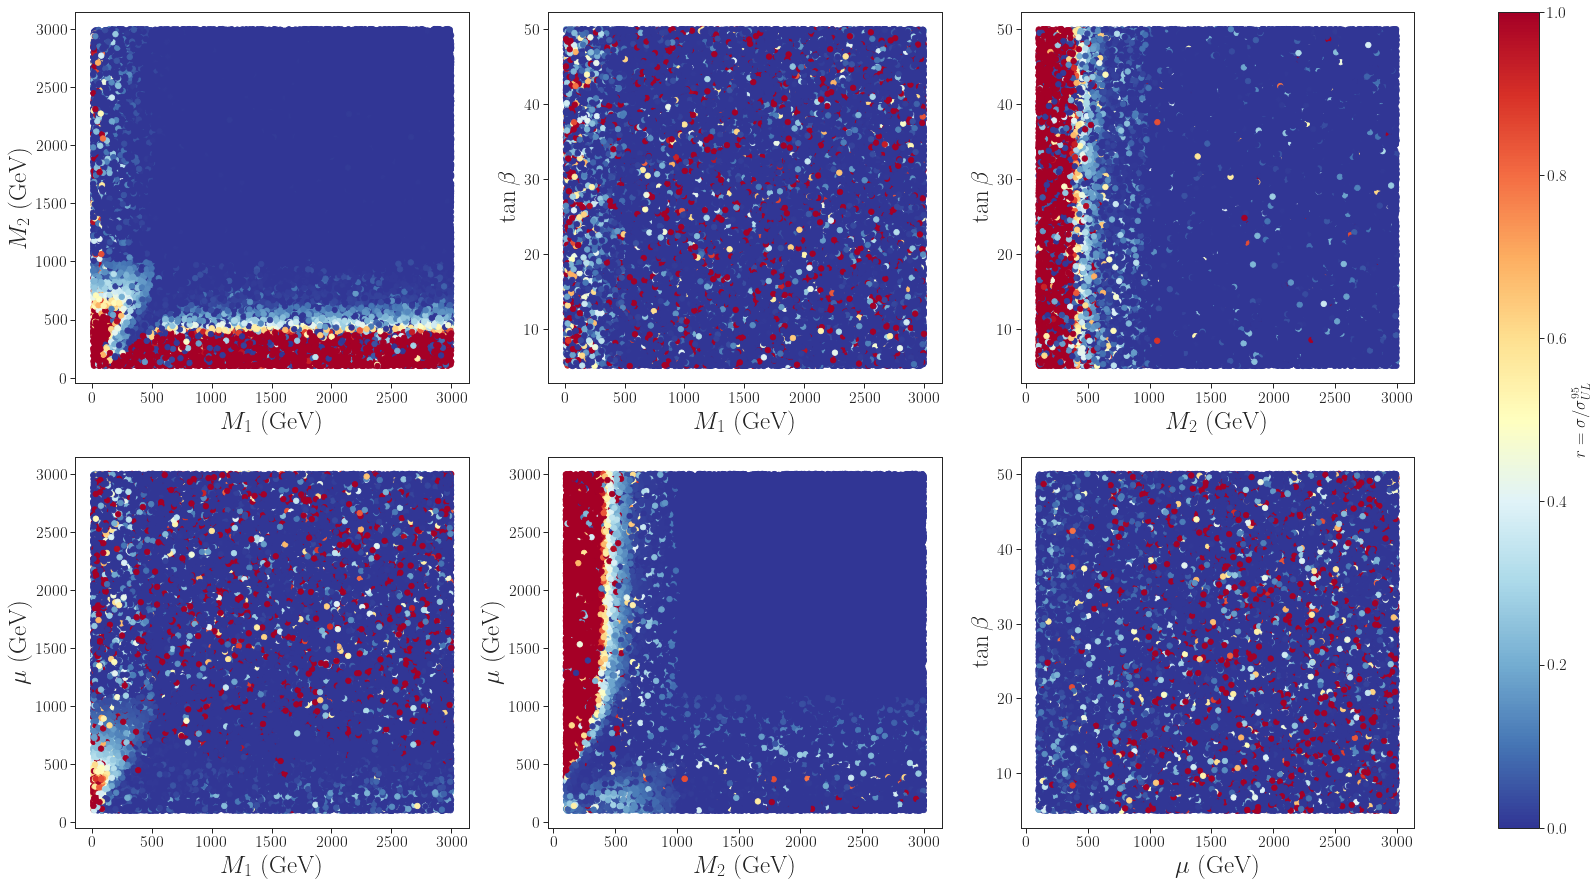

In [19]:
cm = plt.cm.get_cmap('RdYlBu_r')
fig, axes = plt.subplots(nrows=2,ncols=3,figsize=(30,15))
axislabels = {'extpar.1' : r'$M_1$ (GeV)',
              'extpar.2' : r'$M_2$ (GeV)',
              'extpar.23' : r'$\mu$ (GeV)',
             'extpar.25' : r'$\tan\beta$'}

ii = 0
jj = 0
for ix,xvar in enumerate(axislabels):
    for iy,yvar in enumerate(axislabels):
        if iy <= ix: continue
        ax = axes[ii,jj]
        x = dataDF[xvar]
        y = dataDF[yvar]
        z = dataDF['ExptRes.result0.r']
        x = x[z.argsort()]
        y = y[z.argsort()]
        z = z[z.argsort()]        
        a = ax.scatter(x,y,c=z,s=30,vmin=0,vmax=1,cmap=cm)
        ax.set_ylabel(axislabels[yvar],fontsize = 25)
        ax.set_xlabel(axislabels[xvar],fontsize = 25)    
        ii += 1
        if ii >= axes.shape[0]:
            ii = 0
            jj += 1

cb = fig.colorbar(a, ax=axes.ravel().tolist())
cb.set_label(r'$r = \sigma/\sigma_{UL}^{95}$')


plt.show()

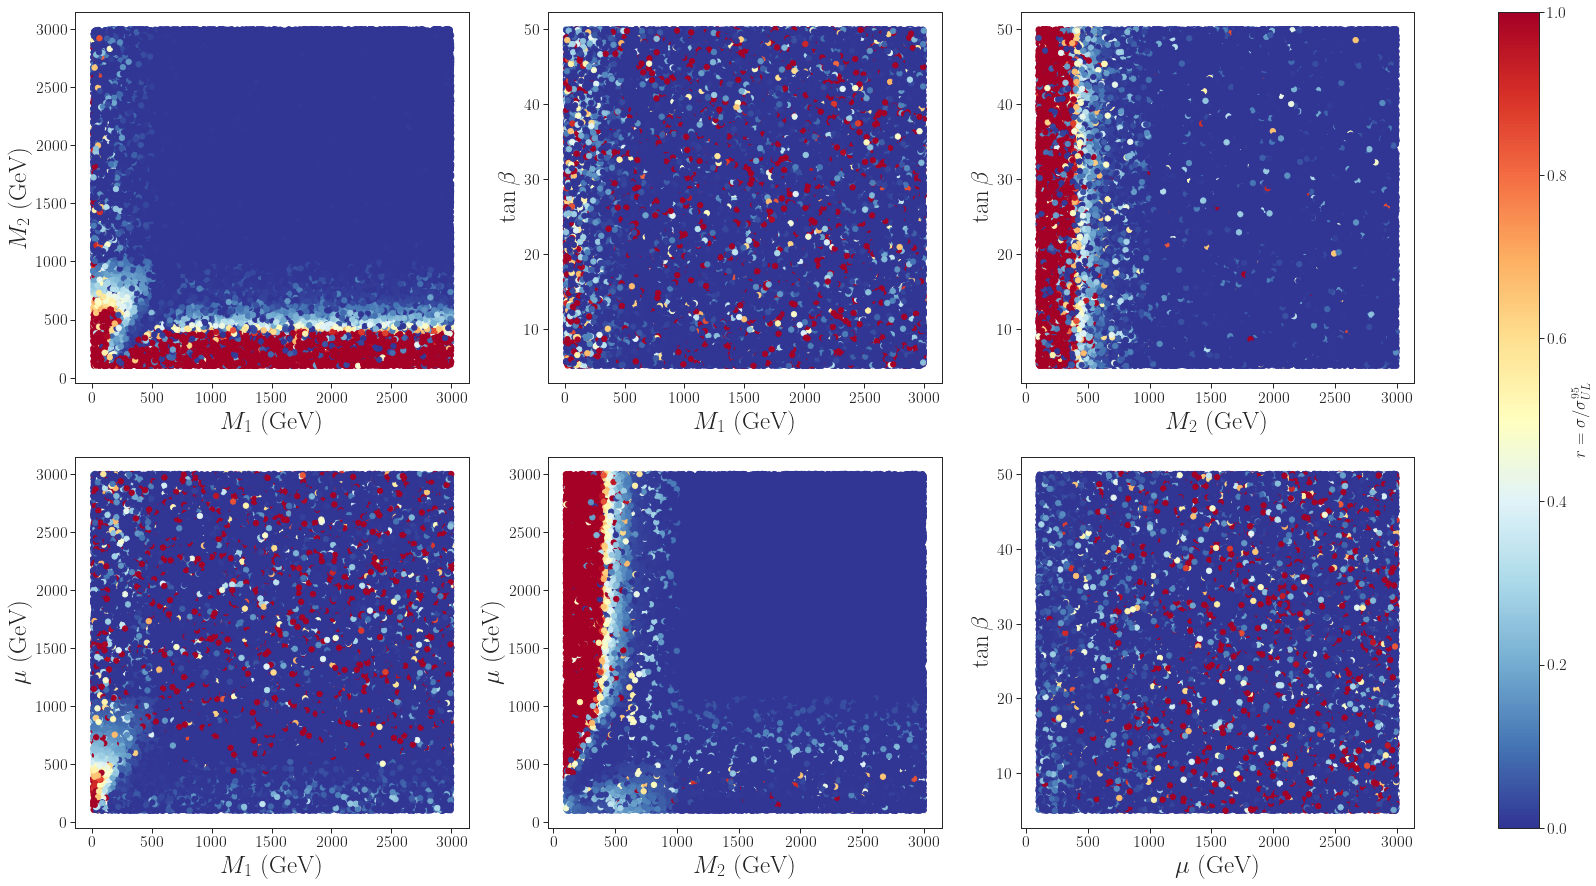

In [20]:
cm = plt.cm.get_cmap('RdYlBu_r')
fig, axes = plt.subplots(nrows=2,ncols=3,figsize=(30,15))
axislabels = {'extpar.1' : r'$M_1$ (GeV)',
              'extpar.2' : r'$M_2$ (GeV)',
              'extpar.23' : r'$\mu$ (GeV)',
             'extpar.25' : r'$\tan\beta$'}

ii = 0
jj = 0
for ix,xvar in enumerate(axislabels):
    for iy,yvar in enumerate(axislabels):
        if iy <= ix: continue
        ax = axes[ii,jj]
        x = dataDF[xvar]
        y = dataDF[yvar]
        z = dataDF['ExptRes.result0.r']
        x = x[(-z).argsort()]
        y = y[(-z).argsort()]
        z = z[(-z).argsort()]        
        a = ax.scatter(x,y,c=z,s=30,vmin=0,vmax=1,cmap=cm)
        ax.set_ylabel(axislabels[yvar],fontsize = 25)
        ax.set_xlabel(axislabels[xvar],fontsize = 25)    
        ii += 1
        if ii >= axes.shape[0]:
            ii = 0
            jj += 1

cb = fig.colorbar(a, ax=axes.ravel().tolist())
cb.set_label(r'$r = \sigma/\sigma_{UL}^{95}$')


plt.show()

In [21]:
# # Count points with 0.9 <= r < 1
# border = dataDF[(dataDF['ExptRes.result0.r'] > 0.7) & (dataDF['ExptRes.result0.r'] < 1.0)]
# print('%i files found' %len(border))
# #Copy files to ../EWino/data/slha_scanRandom_border
# for f in border['filename']:
#     f_old = os.path.join('../EWino/data/slha_scanRandom/',f)
#     f_new = os.path.join('../EWino/data/slha_scanRandom_border/',f)
#     shutil.copyfile(f_old,f_new)